# Diyabet Tahmini

Bu veri seti; en az 21 yaşında, kadın ve Pima Indian ırkından insanlardan oluşur. Bu insanların verilen belirli özellikleri ile bu kişilerin diyabet hastası olup olmadığını tahminleyeceğiz.

In [19]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
df = pd.read_csv("diabetes.csv")

In [21]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


* Pregnancies = Hamile kalma sayısı
* Glucose = Glikoz
* Blood Pressure = Kan basıncı
* Skin Thickness = Deri kalınlığı
* Insulin = İnsülin
* BMI (Body Mass Index) = Beden kitle endeksi
* Diabetes Pedigree Function = Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon
* Age = Yaş
* Outcome = Diyabet olup olmadığı bilgisi (bu bizim target yani hedefimiz amacımız bunu tahminlemek)

In [22]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('ANN', MLPClassifier()))

In [23]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)
# test %20, train %80 şeklinde ayırıyoruz

In [24]:
for name,model in models:
    mod = model.fit(X_train,y_train) #trainleri modele fit etmek
    y_pred = mod.predict(X_test) # tahmin
    acc = accuracy_score(y_test, y_pred) #rmse hesabı
    cvscore = cross_val_score(model, X,y, cv = 10).mean()
    print("Holdout Method:",end=" ")
    print(name,acc) #yazdırılacak kısım
    print("Cross Val Score",end=" ")
    print(name,cvscore)
    print("------------------------------------")
# yukarıdaki döngüde models listesinin içinde geziyoruz.
#"name" tuple'ın ilk elemanı, model ise 2. elemanı oluyor. 
#Yani "LR" = name, LogisticRegression() = model. döngü içerisinde klasik fit predict işlemlerimizi yapıyoruz. 
#Daha sonra bu bir sınıflandırma algoritması olduğu için accuracy (doğruluk) oranını hesaplıyoruz. 
#Ekstra olarak cross validation ile de bütün veri üzerinde bir çalışma yapıyoruz.

Holdout Method: LR 0.8311688311688312
Cross Val Score LR 0.7721804511278195
------------------------------------
Holdout Method: CART 0.7402597402597403
Cross Val Score CART 0.706971975393028
------------------------------------
Holdout Method: NB 0.8051948051948052
Cross Val Score NB 0.7564935064935066
------------------------------------
Holdout Method: ANN 0.6883116883116883
Cross Val Score ANN 0.7161483253588516
------------------------------------


Şimdi bu veri seti üzerinde yapacağımız oynamalarla bu accuracy değerlerini yükseltmeye çalışacağız.

In [26]:
df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] = df[["Glucose","BloodPressure","SkinThickness",
                                                                      "Insulin","BMI"]].replace(0,np.NaN)

Yukarıdaki kod bloğunda 5 değişkendeki 0 olan değerlerin tamamını NaN yani boş anlamına gelen bir hale çevirdik.

Ayrıca 0 olması imkansız olan bazı değerler vardı. Bu değerleri bizim bir şekilde 0 değil boş değer olarak göstermemiz gerekir. Çünkü yaşayan bir insanın Glikoz oranı, kan basıncı, deri kalınlığı, insülini ve beden kitle endeksi kesinlikle 0 olamaz.

Şimdi 0 yerine NaN atadığımız kaç adet satır var görelim.

In [27]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Görüldüğü gibi çok fazla gürültülü veri var. 768 satır olan bir veri setinde 374 satırın Insulin değişkeni aslında boş ama veri setine 0 olarak girildiği için gürültü oluşturuyor.

Şimdi bu NaN yani boş verileri doldurmak veya silmek zorundayız. Çünkü algoritmaya NaN veri girişi yaparsak hatayla karşılaşırız.

Boş veri bulunduran satırları silmek bu veri seti için büyük bir hata olur. Çünkü veri setimizde zaten 768 adet satır var. Bu bile yeterli değilken bunu bir de azaltmak proje için iyi sonuçlar doğurmaz. 768 olan satır sayımız 392 olur.

Şimdi verileri silme yerine doldurma işine bakalım. Bunun için yine bir döngü oluşturalım ve Glucose, BloodPressure, SkinThickness, Insulin, BMI değişkenlerini dolduralım.

In [28]:
naValues = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

for i in naValues:
    df[i][(df[i].isnull()) & (df["Outcome"] == 0)] = df[i][(df[i].isnull()) & (df["Outcome"] == 0)].fillna(df[i][df["Outcome"] == 0].mean())
    df[i][(df[i].isnull()) & (df["Outcome"] == 1)] = df[i][(df[i].isnull()) & (df["Outcome"] == 1)].fillna(df[i][df["Outcome"] == 1].mean())

In [29]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [30]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [33]:
df.shape

(768, 9)

In [34]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

<AxesSubplot:>

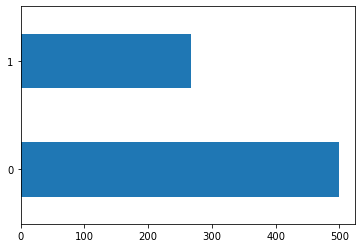

In [35]:
df.Outcome.value_counts().plot.barh()

In [36]:
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.80,0.90,0.95,0.99])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000
mean,3.845052,121.697358,72.428141,29.247042,157.003527,32.44642,0.471876,33.240885,0.348958
std,3.369578,30.462008,12.106044,8.923908,88.860914,6.87897,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.20000,0.078000,21.000000,0.000000
1%,0.000000,67.670000,44.000000,10.000000,24.340000,19.50000,0.094680,21.000000,0.000000
5%,0.000000,80.000000,52.000000,14.350000,50.000000,22.23500,0.140350,21.000000,0.000000
10%,0.000000,86.700000,58.000000,18.000000,67.000000,24.00000,0.165000,22.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.50000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,130.287879,32.05000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,33.000000,206.846154,36.60000,0.626250,41.000000,1.000000


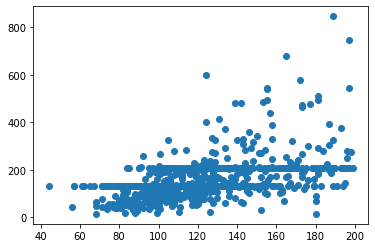

In [44]:
plt.scatter(df.Glucose,df.Insulin)

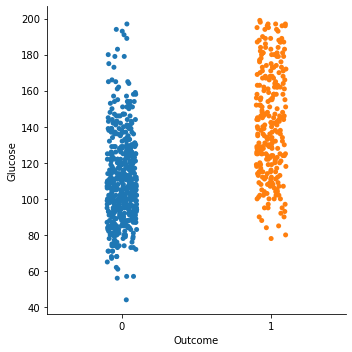

In [45]:
sns.catplot(x = "Outcome", y = "Glucose", data = df)

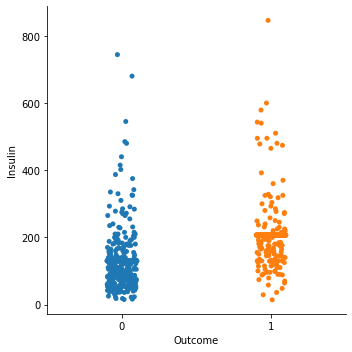

In [46]:
sns.catplot(x = "Outcome", y = "Insulin", data = df)

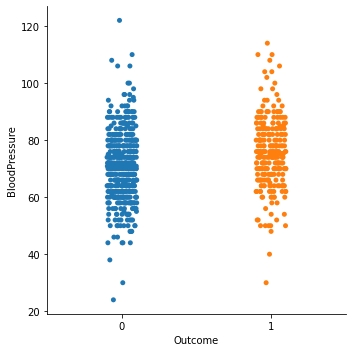

In [47]:
sns.catplot(x = "Outcome", y = "BloodPressure", data = df)

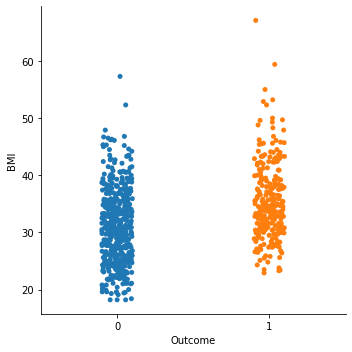

In [48]:
sns.catplot(x = "Outcome", y = "BMI", data = df)

<AxesSubplot:>

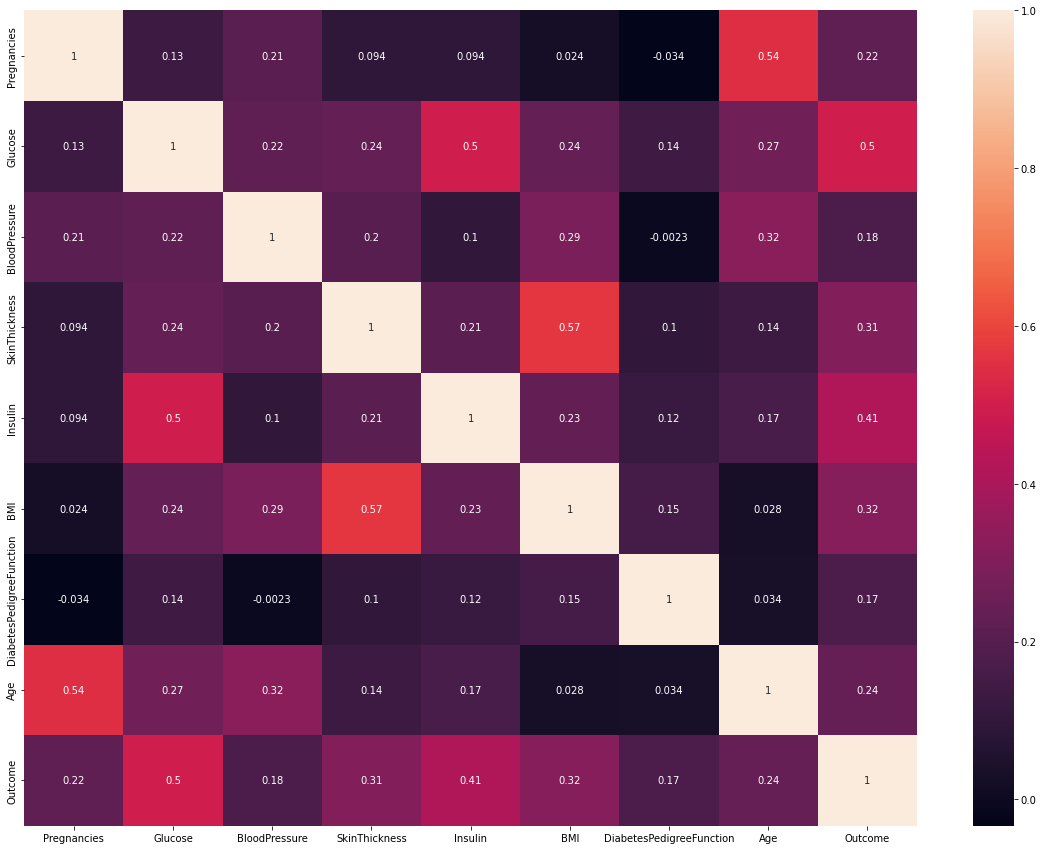

In [53]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df.corr(),annot=True,ax=ax)

Şimdi aykırı değerleri belirleyip onları baskılayacağız. (IQR)

In [54]:
for feature in df:

    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3-Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR

    if df[(df[feature] > upper) | (df[feature] < lower)].any(axis=None):
        print(feature,"yes")
        print(df[(df[feature] > upper) | (df[feature] < lower)].shape[0])
        print("lower",lower,"\nupper",upper)
        df.loc[df[feature] > upper,feature] = upper
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness yes
1
lower -30.124999999999993 
upper 88.475
Insulin yes
3
lower -314.5 
upper 657.5
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


Yukarıda gördüğünüz gibi aykırı değer bulundurmayan değişkenlerin yanında “no”, bulunduranların yanında ise “yes” yazıyor. Alt satırlara bakıldığında da görülüyor, alt ve üst sınırları da sayısal olarak belirtilmiş. Yukarıdaki kod bloğunda df.loc[df[feature] > upper,feature] = upper kısmında bütün üst sınırdan büyük sayıları üst sınıra eşitledik. Buna baskılama denir.

Şimdi de belirli özellikleri segmentlere ayıracağız. Örneğin beden kitle endeksi 18.5'dan düşük olan kişileri “underweight” olarak sınıflandırmak gibi..

In [56]:
df['BMIRanges'] = pd.cut(x=df['BMI'], bins=[0,18.5,25,30,100],labels = ["Underweight","Healthy",
                                                                        "Overweight","Obese"])

Yukarıdaki kod bloğu df dataFrame’e “BMIRanges” adında yeni bir sütun (değişken) ekledi.
Bu değişken: Beden kitle endekslerine göre insanları Underweight (18.5-), Healthy(18.5–25), Overweight(25–30) veya Obese(30+) olarak sınıflandırdı.

In [57]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMIRanges
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1,Obese
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1,Healthy
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0,Overweight
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1,Obese


Yeni bir sütun (değişken) daha ekleyeceğiz. Bu değişken, insülin değerlerinin normal mi anormal mi olduğunu belirtecek.

In [59]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"
    
df = df.assign(INSULIN_DESC=df.apply(set_insulin, axis=1))

Bu kod bloğuna göre, Insulin değeri 16 ile 166 arasında olan değerler normal; Bu aralığın dışında olan değerler ise anormal olarak kabul edilir.

In [60]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMIRanges,INSULIN_DESC
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1,Obese,Abnormal
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0,Overweight,Normal
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1,Healthy,Abnormal
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0,Overweight,Normal
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1,Obese,Abnormal


Şimdi Glikoz ile ilgili bir sınıflandırma yapacağız.

In [61]:
df['NewGlucose'] = pd.cut(x=df['Glucose'], bins=[0,70,99,126,200],labels = ["Low","Normal","Secret","High"])

In [62]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMIRanges,INSULIN_DESC,NewGlucose
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1,Obese,Abnormal,High
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1,Healthy,Abnormal,High
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1,Obese,Abnormal,High


Yine yeni bir sütun ekledik ve sınıflandırma yaptık. Bu değişken glikoz değerlerini: Low(70-), Normal(70–99), Secret(99–126) ve High (126–200) olarak sınıflandırır.

Şimdi, elimizdeki sözel sınıfları sayılara çevirmek için get_dummies (One Hot Encoding) uygulamasını yapıyoruz.

In [63]:
df = pd.get_dummies(df,drop_first=True)

In [64]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMIRanges_Healthy,BMIRanges_Overweight,BMIRanges_Obese,INSULIN_DESC_Normal,NewGlucose_Normal,NewGlucose_Secret,NewGlucose_High
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1,0,0,1,0,0,0,1
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0,0,1,0,1,1,0,0
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1,1,0,0,0,0,0,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0,0,1,0,1,1,0,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1,0,0,1,0,0,0,1


Görüldüğü gibi DataFrame’in sonuna yukarıda gördüğünüz sütunlar eklenmiş oldu.

Şimdi değişkenleri ölçeklendirme kısmına geçelim.

In [65]:
from sklearn.preprocessing import RobustScaler

In [66]:
r_scaler = RobustScaler()
df_r = r_scaler.fit_transform(df.drop(["Outcome","BMIRanges_Healthy","BMIRanges_Overweight",
                                       "BMIRanges_Obese","INSULIN_DESC_Normal","NewGlucose_Normal",
                                       "NewGlucose_Secret","NewGlucose_High"],axis=1))

df_r = pd.DataFrame(df_r, columns=["Pregnancies","Glucose","BloodPressure","SkinThickness",
                                   "Insulin","BMI","DiabetesPedigreeFunction","Age"])

In [67]:
df_r

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.751515,0.000,0.875,0.897033,0.170330,0.665359,1.235294
1,-0.4,-0.775758,-0.375,0.125,0.000000,-0.598901,-0.056209,0.117647
2,1.0,1.600000,-0.500,0.625,0.897033,-0.961538,0.783007,0.176471
3,-0.4,-0.678788,-0.375,-0.625,-0.425185,-0.434066,-0.537255,-0.470588
4,-0.6,0.484848,-2.000,0.875,0.441873,1.214286,5.007843,0.235294
...,...,...,...,...,...,...,...,...
763,1.4,-0.387879,0.250,2.500,0.582476,0.093407,-0.526797,2.000000
764,-0.2,0.121212,-0.125,-0.125,0.000000,0.521978,-0.084967,-0.117647
765,0.4,0.096970,0.000,-0.625,-0.214279,-0.642857,-0.333333,0.058824
766,-0.4,0.218182,-0.750,0.625,0.897033,-0.214286,-0.061438,1.058824


In [68]:
df = pd.concat([df_r,df[["Outcome","BMIRanges_Healthy","BMIRanges_Overweight",
                         "BMIRanges_Obese","INSULIN_DESC_Normal","NewGlucose_Normal",
                         "NewGlucose_Secret","NewGlucose_High"]]],axis=1)

In [69]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMIRanges_Healthy,BMIRanges_Overweight,BMIRanges_Obese,INSULIN_DESC_Normal,NewGlucose_Normal,NewGlucose_Secret,NewGlucose_High
0,0.6,0.751515,0.000,0.875,0.897033,0.170330,0.665359,1.235294,1,0,0,1,0,0,0,1
1,-0.4,-0.775758,-0.375,0.125,0.000000,-0.598901,-0.056209,0.117647,0,0,1,0,1,1,0,0
2,1.0,1.600000,-0.500,0.625,0.897033,-0.961538,0.783007,0.176471,1,1,0,0,0,0,0,1
3,-0.4,-0.678788,-0.375,-0.625,-0.425185,-0.434066,-0.537255,-0.470588,0,0,1,0,1,1,0,0
4,-0.6,0.484848,-2.000,0.875,0.441873,1.214286,5.007843,0.235294,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.4,-0.387879,0.250,2.500,0.582476,0.093407,-0.526797,2.000000,0,0,0,1,0,0,1,0
764,-0.2,0.121212,-0.125,-0.125,0.000000,0.521978,-0.084967,-0.117647,0,0,0,1,1,0,1,0
765,0.4,0.096970,0.000,-0.625,-0.214279,-0.642857,-0.333333,0.058824,0,0,1,0,1,0,1,0
766,-0.4,0.218182,-0.750,0.625,0.897033,-0.214286,-0.061438,1.058824,1,0,0,1,0,0,1,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
 9   BMIRanges_Healthy         768 non-null    uint8  
 10  BMIRanges_Overweight      768 non-null    uint8  
 11  BMIRanges_Obese           768 non-null    uint8  
 12  INSULIN_DESC_Normal       768 non-null    uint8  
 13  NewGlucose_Normal         768 non-null    uint8  
 14  NewGlucose

RobustScaler ile verimizi ölçeklendirdik. Yani artık verimizde daha küçük sayılarla uğraşacağız ve bu bize algoritmalarda performans sağlayacak.

Sınıflandırma olan değerlerimize RobustScaler uygulamadık. Çünkü sınıflandırma olan değişkenlerimizde her sayı bir sınıfı temsil ettiği için bir ölçeklemeye ihtiyacımız yok. Bu dataFrame için sınıflandırma değişkenleri sadece 0 ve 1 değişkenlerini alan değişkenlerdir.

Şimdi tekrardan başta yaptığımız gibi tüm algoritmaları son haliyle uygulayacağız ve accuracy’deki değişimi gözlemleyeceğiz.

In [71]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)

for name,model in models:
    mod = model.fit(X_train,y_train) #trainleri modele fit etmek
    y_pred = mod.predict(X_test) # tahmin
    acc = accuracy_score(y_test, y_pred) #rmse hesabı
    cvscore = cross_val_score(model, X,y, cv = 10).mean()
    print("Holdout Method:",end=" ")
    print(name,acc) #yazdırılacak kısım
    print("Cross Val Score",end=" ")
    print(name,cvscore)
    print("------------------------------------")

Holdout Method: LR 0.8636363636363636
Cross Val Score LR 0.8462576896787424
------------------------------------
Holdout Method: CART 0.8766233766233766
Cross Val Score CART 0.8502734107997266
------------------------------------
Holdout Method: NB 0.7857142857142857
Cross Val Score NB 0.8032638414217361
------------------------------------
Holdout Method: ANN 0.8896103896103896
Cross Val Score ANN 0.8397983595352017
------------------------------------


In [72]:
import pickle

In [ ]:
#data = {"model": mod, "le_country": le_country, "le_education": le_education}

In [ ]:
#with open('saved_steps.pkl', 'wb') as file:
    #pickle.dump(data, file)

In [ ]:
#with open('saved_steps.pkl', 'rb') as file:
    #data = pickle.load(file)